In [74]:
import torch
import torch.nn as nn

import model as model_no
import numpy as np
import argparse

from network import Encoder

from data_list import ImageList
import pre_process as prep

In [41]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [79]:
def tsne_visualize(source, target, model, name=None):
    tsne =  TSNE(n_components=2)

    embeds = tsne.fit_transform(np.concatenate([source, target]))
    
    plt.figure(figsize=(15, 5))
    src_len = source.shape[0]
    plt.scatter(embeds[:src_len, 0], embeds[:src_len, 1], marker='.', color='blue', label='source')
    plt.scatter(embeds[src_len:, 0], embeds[src_len:, 1], marker='.', color='red', label='target')
    plt.title(f"Distribution of Features For: {model}")
    plt.legend()
    if name:
        plt.savefig(f"./tSNE-viz/{name}.png")
    plt.show()

In [20]:
args = {}
args['gpu_id'] = '0'
args['dataset'] = 'office31'
args['target'] = 'dslr'
args['batch_size'] = 1
args['data_dir'] = '/datasets/cs252d-sp22-a00-public/hw4_data/office31'

file_path = {
        "amazon": "./data/office31/amazon.txt" ,
        "webcam": "./data/office31/webcam.txt",
        "dslr": "./data/office31/dslr.txt" ,
    } 
dataset_test = file_path[args['target']]

###### Creating Dataset Loaders

In [72]:
dataset_loaders = {}
amazon_dataset_list = ImageList(args["data_dir"], open(file_path['amazon']).readlines(), transform=prep.image_test(resize_size=256, crop_size=224))
print("Size of Aamzon dataset:" , len(amazon_dataset_list))
dslr_dataset_list = ImageList(args["data_dir"], open(file_path['dslr']).readlines(), transform=prep.image_test(resize_size=256, crop_size=224))
print("Size of dslr dataset:" , len(dslr_dataset_list))


dataset_loaders["amazon"] = torch.utils.data.DataLoader(amazon_dataset_list, batch_size=1, shuffle=False, drop_last=False)
dataset_loaders["dslr"] = torch.utils.data.DataLoader(dslr_dataset_list, batch_size=1, shuffle=False, drop_last=False)

Size of Aamzon dataset: 2817
Size of dslr dataset: 498


### Generate DANN Feature Embeddings

In [57]:
args['checkpoint'] = './snapshot/office31/dann_v1/amazon-dslr/best_model.pth'

dann_source = []
dann_target = []

In [58]:
# Setup Network
# Get Features from the Encoder
my_net = Encoder(total_classes=None)
my_net = my_net.cuda()
saved_state_dict = torch.load(args['checkpoint'])
my_net.load_state_dict(saved_state_dict, strict=False)
my_net.eval()

print("Generating features for Source Dataset Images")
start_test = True
iter_test = iter(dataset_loaders["amazon"])
with torch.no_grad():
    for i in range(len(dataset_loaders['amazon'])):
        print("{0}/{1}".format(i,len(dataset_loaders['amazon'])) , end="\r")
        data = iter_test.next()
        inputs = data[0].cuda()
        labels = data[1].cuda()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs, _ = my_net(inputs)
        dann_source.append(outputs.detach().cpu().numpy())
        
print("Generating features for Target Dataset Images")
iter_test = iter(dataset_loaders["dslr"])
with torch.no_grad():
    for i in range(len(dataset_loaders['dslr'])):
        print("{0}/{1}".format(i,len(dataset_loaders['dslr'])) , end="\r")
        data = iter_test.next()
        inputs = data[0].cuda()
        labels = data[1].cuda()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs, _ = my_net(inputs)
        dann_target.append(outputs.detach().cpu().numpy())

Generating features for Source Dataset Images
Generating features for Target Dataset Images


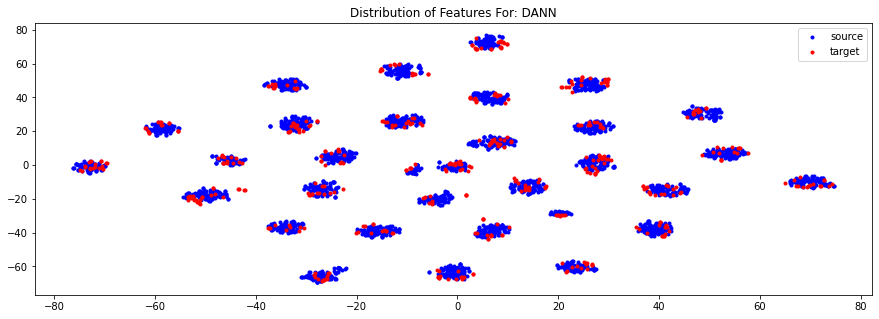

In [80]:
dann_source_arr, dann_target_arr = np.array(dann_source).reshape(-1,256), np.array(dann_target).reshape(-1,256)

tsne_visualize(dann_source_arr, dann_target_arr, model='DANN', name='DANN')

### Generate CDAN Feature Embeddings

In [69]:
args['checkpoint'] = './snapshot/office31/cdan_v1/amazon-dslr/best_model.pth'

cdan_source = []
cdan_target = []

In [70]:
# Setup Network
# Get Features from the Encoder
my_net = Encoder(total_classes=None)
my_net = my_net.cuda()
saved_state_dict = torch.load(args['checkpoint'])
my_net.load_state_dict(saved_state_dict, strict=False)
my_net.eval()

print("Generating features for Source Dataset Images")
start_test = True
iter_test = iter(dataset_loaders["amazon"])
with torch.no_grad():
    for i in range(len(dataset_loaders['amazon'])):
        print("{0}/{1}".format(i,len(dataset_loaders['amazon'])) , end="\r")
        data = iter_test.next()
        inputs = data[0].cuda()
        labels = data[1].cuda()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs, _ = my_net(inputs)
        cdan_source.append(outputs.detach().cpu().numpy())
        
print("Generating features for Target Dataset Images")
iter_test = iter(dataset_loaders["dslr"])
with torch.no_grad():
    for i in range(len(dataset_loaders['dslr'])):
        print("{0}/{1}".format(i,len(dataset_loaders['dslr'])) , end="\r")
        data = iter_test.next()
        inputs = data[0].cuda()
        labels = data[1].cuda()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs, _ = my_net(inputs)
        cdan_target.append(outputs.detach().cpu().numpy())

Generating features for Source Dataset Images
Generating features for Target Dataset Images


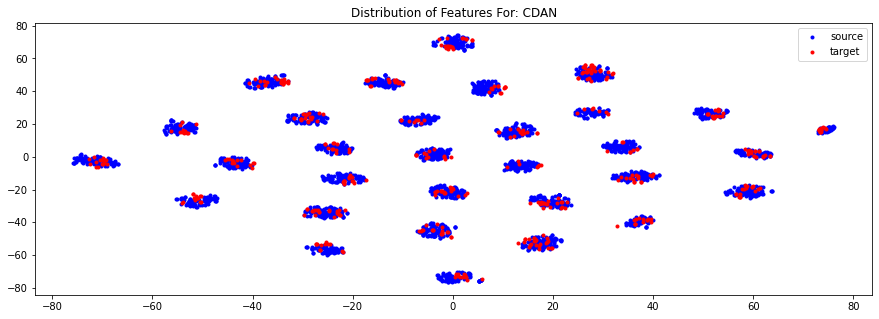

In [81]:
cdan_source_arr, cdan_target_arr = np.array(cdan_source).reshape(-1,256), np.array(cdan_target).reshape(-1,256)

tsne_visualize(cdan_source_arr, cdan_target_arr, model='CDAN', name='CDAN')

### Generate Basic Feature Embeddings (before Domain Adaptation)

In [75]:
args['checkpoint'] = '/datasets/cs252d-sp22-a00-public/hw4_data/SourceOnly_amazon2dslr/best_model.pth.tar'

basic_source = []
basic_target = []

In [76]:
# Setup Network
# Get Features from the Encoder
my_net = Encoder(total_classes=None)
my_net = my_net.cuda()
saved_state_dict = torch.load(args['checkpoint'])
my_net.load_state_dict(saved_state_dict, strict=False)
my_net.eval()

print("Generating features for Source Dataset Images")
start_test = True
iter_test = iter(dataset_loaders["amazon"])
with torch.no_grad():
    for i in range(len(dataset_loaders['amazon'])):
        print("{0}/{1}".format(i,len(dataset_loaders['amazon'])) , end="\r")
        data = iter_test.next()
        inputs = data[0].cuda()
        labels = data[1].cuda()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs, _ = my_net(inputs)
        basic_source.append(outputs.detach().cpu().numpy())
        
print("Generating features for Target Dataset Images")
iter_test = iter(dataset_loaders["dslr"])
with torch.no_grad():
    for i in range(len(dataset_loaders['dslr'])):
        print("{0}/{1}".format(i,len(dataset_loaders['dslr'])) , end="\r")
        data = iter_test.next()
        inputs = data[0].cuda()
        labels = data[1].cuda()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs, _ = my_net(inputs)
        basic_target.append(outputs.detach().cpu().numpy())

Generating features for Source Dataset Images
Generating features for Target Dataset Images


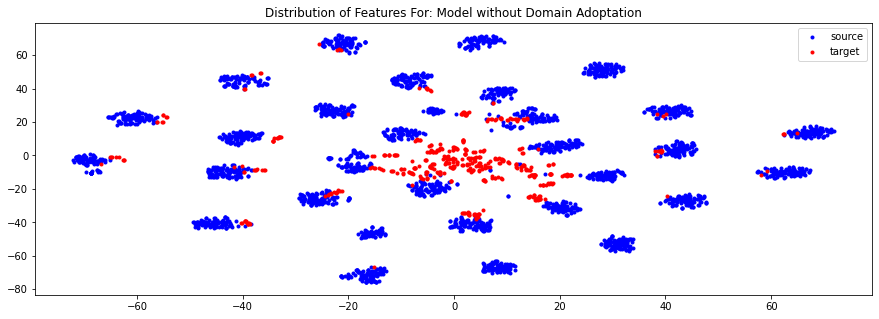

In [82]:
basic_source_arr, basic_target_arr = np.array(basic_source).reshape(-1,256), np.array(basic_target).reshape(-1,256)

tsne_visualize(basic_source_arr, basic_target_arr, model='Model without Domain Adoptation', name='woDomainAdoptation')